In [2]:
import os
import sys

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 8)
import mne
mne.set_log_level('ERROR')

from braindecode.datasets import MOABBDataset
from braindecode.datautil.preprocess import filterbank, preprocess, MNEPreproc, NumpyPreproc
from braindecode.datautil.windowers import create_windows_from_events

sys.path.insert(0, '/home/gemeinl/code/braindecode-features/')
from braindecode_features import *

In [3]:
# My HGD results so far
# manual band selection
# ASC2, 10 min fit time
d = [
    {'subject': 1, 'bands': [(0, 54), (11, 123), (69, 80)], 'cv acc': 94.375},
    {'subject': 2, 'bands': [(11, 15), (20, 60), (40, 70)], 'cv acc': 78.720787},
    {'subject': 3, 'bands': [(9, 29), (18, 36), (40, 77)] , 'cv acc': 88.18181818181818},
    {'subject': 4, 'bands': [(10, 20), (22, 88), (70, 81)], 'cv acc': 97.54738015607581},
    {'subject': 5, 'bands': [(12, 31), (31, 70), (70, 87)], 'cv acc': 95.69444444444445},
    {'subject': 6, 'bands': [(12, 32), (35, 66), (68, 88)], 'cv acc': 80.71647020973924},
    {'subject': 7, 'bands': [(10, 25), (25, 55), (55, 84)], 'cv acc': 78.70632462228138},
    {'subject': 8, 'bands': [(6, 18), (17, 42), (62, 80)], 'cv acc': 82.33892389316027},
    {'subject': 9, 'bands': [(15, 29), (29, 59), (62, 80)], 'cv acc': 89.88636363636364},
    {'subject': 10, 'bands': [(12, 16), (23, 26), (34, 81)], 'cv acc': 86.93181818181819},
    {'subject': 11, 'bands': [(14, 34), (34, 65), (65, 77)], 'cv acc': 92.72727272727272},
    {'subject': 12, 'bands': [(9, 14), (12, 29), (29, 54)], 'cv acc': 92.8409090909091},
    {'subject': 13, 'bands': [(10, 15), (15, 31), (55, 68)], 'cv acc': 83.125},
    {'subject': 14, 'bands': [(8, 42), (17, 33), (48, 89)], 'cv acc': 94.36928992546136},
]
pd.DataFrame(d)

,subject,bands,cv acc
0,1,"[(0, 54), (11, 123), (69, 80)]",94.375000
1,2,"[(11, 15), (20, 60), (40, 70)]",78.720787
2,3,"[(9, 29), (18, 36), (40, 77)]",88.181818
3,4,"[(10, 20), (22, 88), (70, 81)]",97.547380
4,5,"[(12, 31), (31, 70), (70, 87)]",95.694444
5,6,"[(12, 32), (35, 66), (68, 88)]",80.716470
6,7,"[(10, 25), (25, 55), (55, 84)]",78.706325
7,8,"[(6, 18), (17, 42), (62, 80)]",82.338924
8,9,"[(15, 29), (29, 59), (62, 80)]",89.886364
9,10,"[(12, 16), (23, 26), (34, 81)]",86.931818


In [4]:
ds_name = 'Schirrmeister2017'
subject_id = 1
out_path = None#'/home/lukas/Code/HGD/'
n_jobs = 2
agg_func = None#'mean'

#------------------------------------------------------------------------------
# stuffs to optimize
sfreq = 250
# original trials have 4s duration
frequency_bands = [(32, 99), (76, 77), (114, 123)]
trial_start_offset_samples = int(0.5*sfreq)
window_size_samples = 500
window_stride_samples = 500

# clf + hyperparams
#------------------------------------------------------------------------------
factor = 1e6
max_abs_val = 800
trial_stop_offset_samples = 0
sensors = {
    'Schirrmeister2017': (
        'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CCP1h', 'CCP2h', 'CCP3h', 'CCP4h',
        'CCP5h', 'CCP6h', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPP1h',
        'CPP2h', 'CPP3h', 'CPP4h', 'CPP5h', 'CPP6h', 'CPz', 'Cz', 'FC1', 'FC2',
        'FC3', 'FC4', 'FC5', 'FC6', 'FCC1h', 'FCC2h', 'FCC3h', 'FCC4h',
        'FCC5h', 'FCC6h', 'FCz', 'FFC1h', 'FFC2h', 'FFC3h', 'FFC4h', 'FFC5h',
        'FFC6h'
    ),
    'BNCI2014001': (
        'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CPz',
        'Cz', 'FC1', 'FC2', 'FC3', 'FC4', 'FCz', 'Fz', 'P1', 'P2', 'POz', 'Pz'
    ),
}
sensors = sensors[ds_name]
train_eval_split = {
    'Schirrmeister2017': 'run', 
    'BNCI2014001': 'session',
}
eval_name = {
    'Schirrmeister2017': 'test',
    'BNCI2014001': 'session_E',
}

In [5]:
ds = MOABBDataset(
    dataset_name=ds_name,
    subject_ids=[subject_id],
)

In [6]:
# some preprocessing steps
preprocessors = [
    MNEPreproc(
        fn='pick_channels', 
        ch_names=sensors, 
        ordered=True
    ),
    NumpyPreproc(
        fn=lambda x: x * factor
    ),
    NumpyPreproc(
        fn=lambda x: np.clip(x, -max_abs_val, max_abs_val)
    ),
    MNEPreproc(
        fn='resample', 
        sfreq=sfreq
    ),
    # used by connectivity, time, and cross-frequency domain features
    # not used by dft, cwt domain features
    MNEPreproc(
        fn=filterbank, 
        frequency_bands=sorted(frequency_bands, key=lambda b: b[0]), 
        drop_original_signals=False,  
    ),
]

In [7]:
split_indicator = train_eval_split[ds_name]
eval_ds_name = eval_name[ds_name]

In [8]:
# split into train and test session
splits = ds.split(split_indicator)
for split_name, split_ds in splits.items():
    if split_name != eval_ds_name:
        continue
    break
print(split_name)

test


In [9]:
# apply some preprocessing
preprocess(
    concat_ds=split_ds,
    preprocessors=preprocessors,
)
# extract compute windows 
windows_ds = create_windows_from_events(
    concat_ds=split_ds,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=trial_stop_offset_samples,
    drop_last_window=False,
    window_size_samples=window_size_samples,
    window_stride_samples=window_stride_samples,
)

In [10]:
len(windows_ds)

960

In [11]:
for x, y, ind in windows_ds:
    break
x.shape, y, ind

((180, 250), 3, [0, 2625, 2875])

In [16]:
df = extract_windows_ds_features(
    windows_ds=windows_ds,
    frequency_bands=frequency_bands,
    n_jobs=n_jobs,
)

Connectivity
Cross-frequency
CWT
DFT
Time


In [17]:
# save each trial feature matrix (windows x features) to an individual file
if out_path is not None:
    save_features_by_trial(
        df=df, 
        out_path=out_path, 
        subject_id=subject_id, 
        split_name=split_name,
    )

In [18]:
df

Domain    Trial Window Target       Time  ...        Connectivity              \
Feature                       covariance  ... phase_locking_value               
Channel                            C1-C2  ...         FFC3h-FFC6h FFC4h-FFC5h   
Frequency                          32-99  ...             114-123     114-123   
0             0      0      3  -0.066360  ...            0.157286    0.205863   
1             0      1      3  -0.050652  ...            0.252769    0.186949   
2             0      2      3   0.018156  ...            0.130495    0.118346   
3             0      3      3   0.131137  ...            0.051899    0.075057   
4             0      4      3   0.004904  ...            0.093158    0.141693   
..          ...    ...    ...        ...  ...                 ...         ...   
955         159      1      1   0.062039  ...            0.226736    0.210515   
956         159      2      1   0.097013  ...            0.105509    0.268672   
957         159      3      1   0.135999  ...            0.185803    0.326196   
958         159      4      1   0.089473  ...            0.032611    0.077704   
959         159      5      1   0.034531  ...            0.186212    0.132767   

Domain                             
Feature                            
Channel   FFC4h-FFC6h FFC5h-FFC6h  
Frequency     114-123     114-123  
0            0.692033    0.151416  
1            0.647706    0.155703  
2            0.639727    0.145026  
3            0.627171    0.296997  
4            0.592972    0.320754  
..                ...         ...  
955          0.726512    0.294557  
956          0.692571    0.228486  
957          0.565510    0.236926  
958          0.504051    0.108415  
959          0.336864    0.257759  

[960 rows x 10668 columns]

In [20]:
# inspect subsets of the feature data frame
filter_df(
    df=df, 
    query='DFT', 
    exact_match=False, 
    level_to_consider=None,
)

Domain    Target Trial Window        DFT  ...                          \
Feature                          maximum  ...    variance               
Channel                               C1  ...       FFC3h       FFC4h   
Frequency                          32-99  ...     114-123     114-123   
0              3     0      0  40.805969  ...   31.721298   32.252262   
1              3     0      1  44.802074  ...    9.503935   19.836935   
2              3     0      2  29.732462  ...   26.667313   10.795629   
3              3     0      3  35.226177  ...   21.799219   14.791245   
4              3     0      4  38.287865  ...   13.666753   17.721926   
..           ...   ...    ...        ...  ...         ...         ...   
955            1   159      1  31.785318  ...   93.108170  114.070778   
956            1   159      2  40.698151  ...   85.992981  112.546410   
957            1   159      3  50.610546  ...   58.126785   51.617317   
958            1   159      4  30.405659  ...  179.295105   67.126373   
959            1   159      5  62.471554  ...  117.994888   33.729164   

Domain                              
Feature                             
Channel          FFC5h       FFC6h  
Frequency      114-123     114-123  
0            99.871582   35.139320  
1            25.263193   20.628469  
2            78.724045   28.061600  
3            44.468369   27.315252  
4            23.532198   22.680248  
..                 ...         ...  
955        4838.388672  248.800201  
956        4726.959473  184.337280  
957        3333.475830  202.180283  
958        1864.715088  129.156738  
959        5991.532715  154.843292  

[960 rows x 1218 columns]

In [48]:
data = windows_ds.datasets[0].windows.get_data()

In [50]:
data.shape

(960, 180, 250)

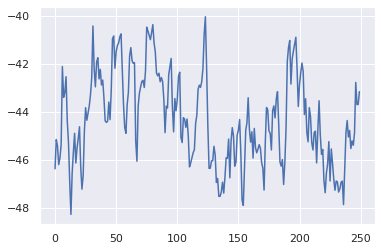

In [33]:
plt.plot(data[0,0])

In [34]:
from scipy.signal import hilbert

In [35]:
data.shape

(960, 180, 250)

In [36]:
analytical_signal = hilbert(data, axis=-1)

In [37]:
analytical_signal.shape

(960, 180, 250)

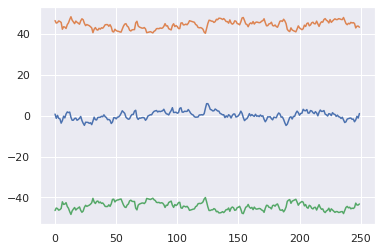

In [42]:
plt.plot(np.imag(analytical_signal[0,0]))
plt.plot(np.abs(analytical_signal[0,0]))
plt.plot(np.real(analytical_signal[0,0]))

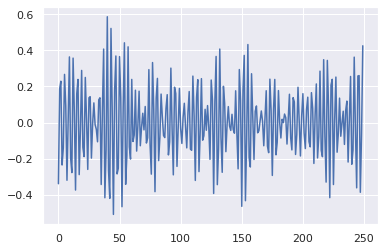

In [87]:
plt.plot(data[100,2])

In [92]:
duration = 1.0
fs = 400.0
samples = int(fs*duration)
t = np.arange(samples) / fs

#We create a chirp of which the frequency increases from 20 Hz to 100 Hz and apply an amplitude modulation.

signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
signal=data[100,123]

#The amplitude envelope is given by magnitude of the analytic signal. The instantaneous frequency can be obtained by differentiating the instantaneous phase in respect to time. The instantaneous phase corresponds to the phase angle of the analytic signal.

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * fs)



Text(0.5, 0, 'time in seconds')

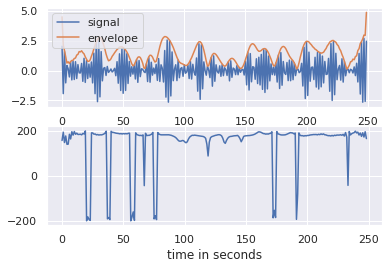

In [93]:
fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.plot(signal, label='signal')
ax0.plot(amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()
ax1 = fig.add_subplot(212)
ax1.plot(instantaneous_frequency)
ax1.set_xlabel("time in seconds")
#ax1.set_ylim(0.0, 120.0)

In [99]:
    def shannon_entropy(X):
        # https://arxiv.org/pdf/2001.08386.pdf
        return -np.sum(X/np.max(X) * np.log2(X/np.max(X)), axis=-1)

In [100]:
shannon_entropy(amplitude_envelope)

114.59081209012189

In [84]:
def PhaseCoherence(freq, timeSeries, FS):
    # https://github.com/emma-holmes/Phase-Coherence-for-Python/blob/master/PhaseCoherence.py
    # Get parameters of input data
    nMeasures	 = np.shape(timeSeries)[0]
    nSamples 	= np.shape(timeSeries)[1]
    nSecs = nSamples / FS
    print('Number of measurements =', nMeasures)
    print('Number of time samples =', nSamples, '=', nSecs, 'seconds')
    
    # Calculate FFT for each measurement (spect is freq x measurements)
    spect = np.fft.fft(timeSeries, axis=1)
    
    # Normalise by amplitude
    spect = spect / abs(spect)
    
    # Find spectrum values for frequency bin of interest
    freqRes = 1 / nSecs;
    foibin = round(freq / freqRes + 1) - 1
    spectFoi = spect[:,foibin]
    
    # Find individual phase angles per measurement at frequency of interest
    anglesFoi = np.arctan2(spectFoi.imag, spectFoi.real)
    
    # PC is root mean square of the sums of the cosines and sines of the angles
    PC = np.sqrt((np.sum(np.cos(anglesFoi)))**2 + (np.sum(np.sin(anglesFoi)))**2) / np.shape(anglesFoi)[0]
    
    # Print the value
    print('----------------------------------');
    print('Phase coherence value = ' + str("{0:.3f}".format(PC)));
        
    return PC

In [85]:
for x, y, ind in windows_ds:
    break

In [86]:
PhaseCoherence(, x, windows_ds.datasets[0].info['sfreq'])

TypeError: PhaseCoherence() missing 2 required positional arguments: 'timeSeries' and 'FS'

In [87]:
import mne

In [137]:
data = windows_ds.datasets[0].windows.get_data(picks=sensors)

In [138]:
data.shape

(320, 45, 500)

In [166]:
%%time
# https://mne.tools/stable/generated/mne.connectivity.spectral_connectivity.html
cons, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(
    data[:1],
    sfreq=windows_ds.datasets[0].windows.info['sfreq'],
)

CPU times: user 81.4 ms, sys: 36.8 ms, total: 118 ms
Wall time: 118 ms


In [167]:
cons.shape

(45, 45, 246)

In [155]:
cons = np.rollaxis(cons, -1, 0)
cons.shape

(246, 45, 45)

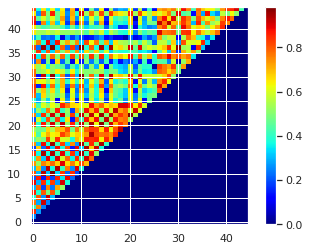

In [163]:
im = plt.imshow(cons[88], origin='lower', cmap='jet')
plt.colorbar(im)

In [164]:
tril_cons = np.array([con[np.tril_indices(cons.shape[-1], k=-1)] for con in cons])

In [165]:
tril_cons.shape

(246, 990)